# Домашняя работа 5. Линейная регрессия. (33 балла)

> Линейная регрессия - это не повод для затяжной депрессии.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #5: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 27.11.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 30.11.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [Первый конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf)
- [Второй конспект лекции про линейную регрессию из курса ФШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture03-linregr.pdf)
- [Теория из курса ODS](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_notebooks/topic04_linear_models/topic4_linear_models_part1_mse_likelihood_bias_variance.ipynb)
- [Материалы из курса от МФТИ](https://www.coursera.org/specializations/machine-learning-data-analysis)
- [Статья про лин.рег. от ODS на habrahabr](https://habrahabr.ru/company/ods/blog/323890/)

## Данные

Возьмем датасет о стоимости домов: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Там же читайте описание данных.

Целевой переменной будет `SalePrice`. То есть мы будем предсказывать стоимость жилья на основе его характеристик. Это задание будет не то чтобы про линейную регрессию, но про попытку построить модель для предсказания цен на дом. В принципе я бы мог еще добавить заданий на более тщательный отбор признаков, логарифмирование признаков у которых сильное смещение "скоса"(skew). Можно было бы анализировать и выпрямлять распределение целевой переменной. Можно было бы генерировать новые признаки из существующих, строить ансаибли моделей. Но тут мы ограничимся пока что.......

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import norm, kurtosis, probplot
from IPython.display import display, Markdown as md
%matplotlib inline

In [3]:
from warnings import filterwarnings

filterwarnings('ignore')

In [5]:
df = pd.read_csv('data/house_prices.csv.gz', index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
assert df.shape == (1460, 80)

In [7]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## 1.0 Анализ целевого признака (3 балла)

Удостоверимся, что раcпределение целевого признака "хорошее", без странных выбросов. В идеале мы хотим видеть нормальное распределени или достаточно похожее на него, без очень длинных "хвостов" выбросов.

_Почему требуется нормальность распределения: ищите объяснения линейной регресси через алгоритмы максимизации правдоподобия. В итоге, грубо говоря, суть сводится к тому, что с ростом объема выборки, оценка максимального правдоподобия лучше описывает нормальное распределение._

[Коэффициент эксцесса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D1%8D%D0%BA%D1%81%D1%86%D0%B5%D1%81%D1%81%D0%B0) показывает степень остроты пика распределения случайной величины. Для нормального распределения он равен `0`. Если хвосты распределения «тяжелее», а пик более «приплюснутый», чем у нормального распределения, то коэффициент < 0. А если хвосты легкие, то больше 0. В нашем случае должно получиться околов `6.5`.

Задание: 
- Нарисуйте график распределения `SalePrice`, используйте аргумент `fit=scipy.stats.norm`, чтобы нарисовать предполагаемое нормальное распределение. Напечатайте значение коэффициент эксцесса `kurtosis` для этого признака.
- Нарисуйте график [scipy.stats.probplot](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html) - он покажет нам реальные квантили выборки и теоретические. По нему можно видеть, на сколько много выьросов и на сколько выборка предсказуема.
- Что вы можете сказать по поводу выборки основываясь на `probplot`.  [wiki](https://en.wikipedia.org/wiki/Normal_probability_plot)

In [8]:
sns.set()

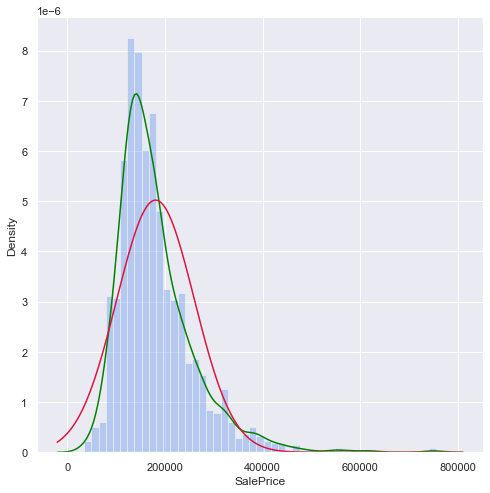

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = sns.distplot(df.SalePrice, color='cornflowerblue', kde=True, fit=norm)
ax.lines[0].set_color('green')
ax.lines[1].set_color('crimson')

In [10]:
print(f'Коэффициент эксцесса с точки зрения scipy: {kurtosis(df.SalePrice)}, с точки зрения pandas: {df.SalePrice.kurtosis(axis=0)}')

Коэффициент эксцесса с точки зрения scipy: 6.509812011089439, с точки зрения pandas: 6.536281860064529


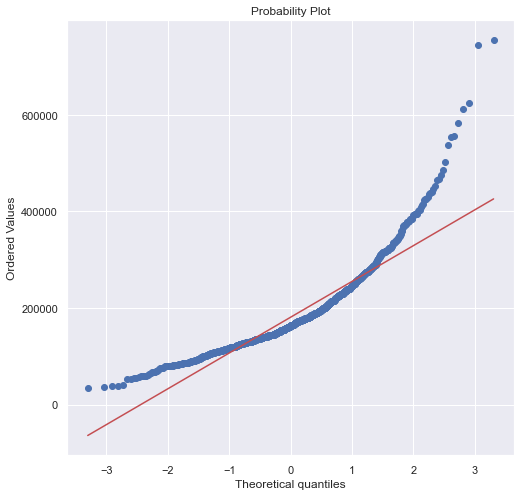

In [11]:
fig = plt.figure(figsize=(8, 8))
probplot(df.SalePrice, plot=fig.add_subplot(111))
plt.show()

## 1.2 Анализ некоторых зависимостей (3 балла)

У нас очень много разных признаков. Любопытно построить разные графики. Позаботьтесь о красоте и наглядности графиков, сделайте так, чтобы они были большие и их можно было прочесть. Даже подписи на графиках должны быть читаемые!!

Задания: Постройте графики, отражающие зависимости этих признаков:
- дата постройки дома и его стоимости
- "качество дома и материалов" и его стоимости
- площадь дома и стоимость

Hints: Вспомните про boxplot, jointplot, lmplot...

<AxesSubplot:ylabel='SalePrice'>

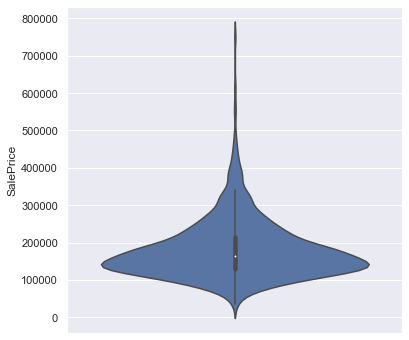

In [12]:
fig = plt.figure(figsize=(6, 6))
sns.violinplot(y=df['SalePrice'])

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

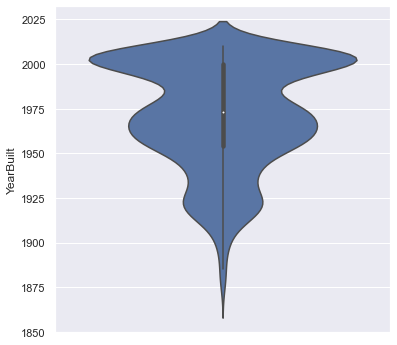

<Figure size 720x720 with 0 Axes>

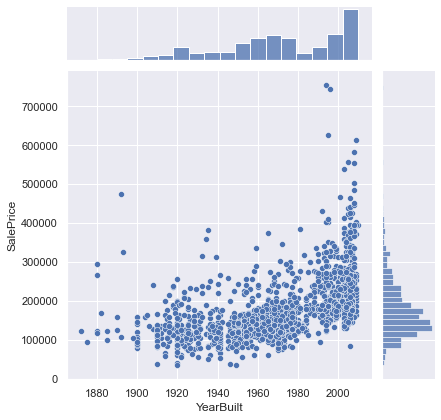

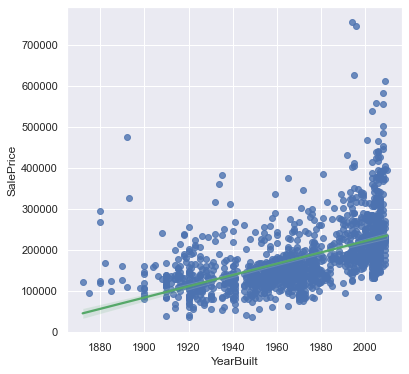

In [13]:
fig = plt.figure(figsize=(6, 6))
sns.violinplot(y=df['YearBuilt'])
fig = plt.figure(figsize=(10, 10))
sns.jointplot(df['YearBuilt'], df['SalePrice'])
fig = plt.figure(figsize=(6, 6))
sns.regplot(df['YearBuilt'], df['SalePrice'], line_kws={'color': 'g'})

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

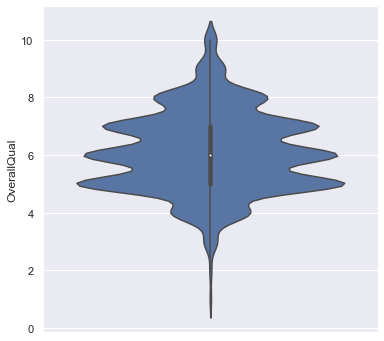

<Figure size 720x720 with 0 Axes>

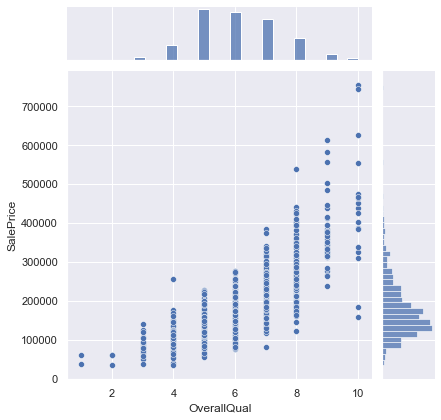

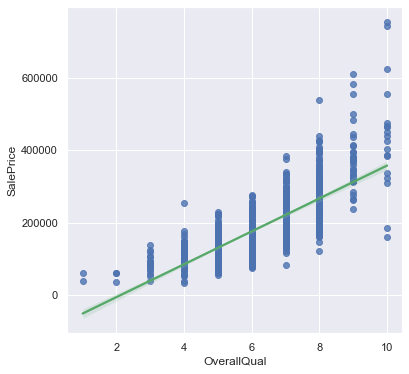

In [14]:
fig = plt.figure(figsize=(6, 6))
sns.violinplot(y=df['OverallQual'])
fig = plt.figure(figsize=(10, 10))
sns.jointplot(df['OverallQual'], df['SalePrice'])
fig = plt.figure(figsize=(6, 6))
sns.regplot(df['OverallQual'], df['SalePrice'], line_kws={'color': 'g'})

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

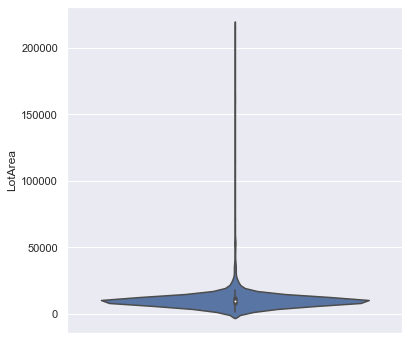

<Figure size 720x720 with 0 Axes>

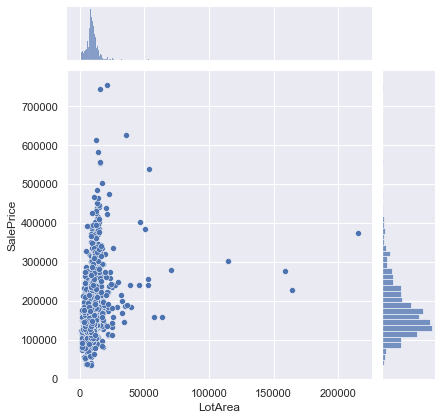

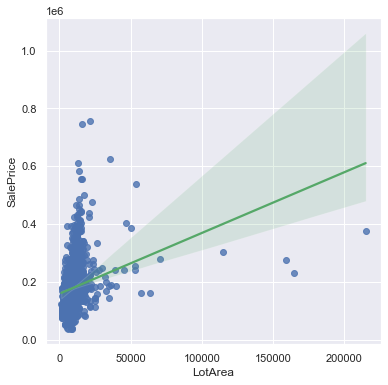

In [15]:
fig = plt.figure(figsize=(6, 6))
sns.violinplot(y=df['LotArea'])
fig = plt.figure(figsize=(10, 10))
sns.jointplot(df['LotArea'], df['SalePrice'])
fig = plt.figure(figsize=(6, 6))
sns.regplot(df['LotArea'], df['SalePrice'], line_kws={'color': 'g'})

## 1.2 Heatmap (3 балла)

Судя по предыдущим графикам, есть некоторые линейные зависимости. Но строить по графику на каждый признак из 80 штук немного долго и не наглядно. Постройте красивый график корреляции всех признаков. Используйте цвета `RdYlGn`, так будет нагляднее. Не забудьте применить маску, чтобы убрать дублирующую половину матрицы.

<AxesSubplot:>

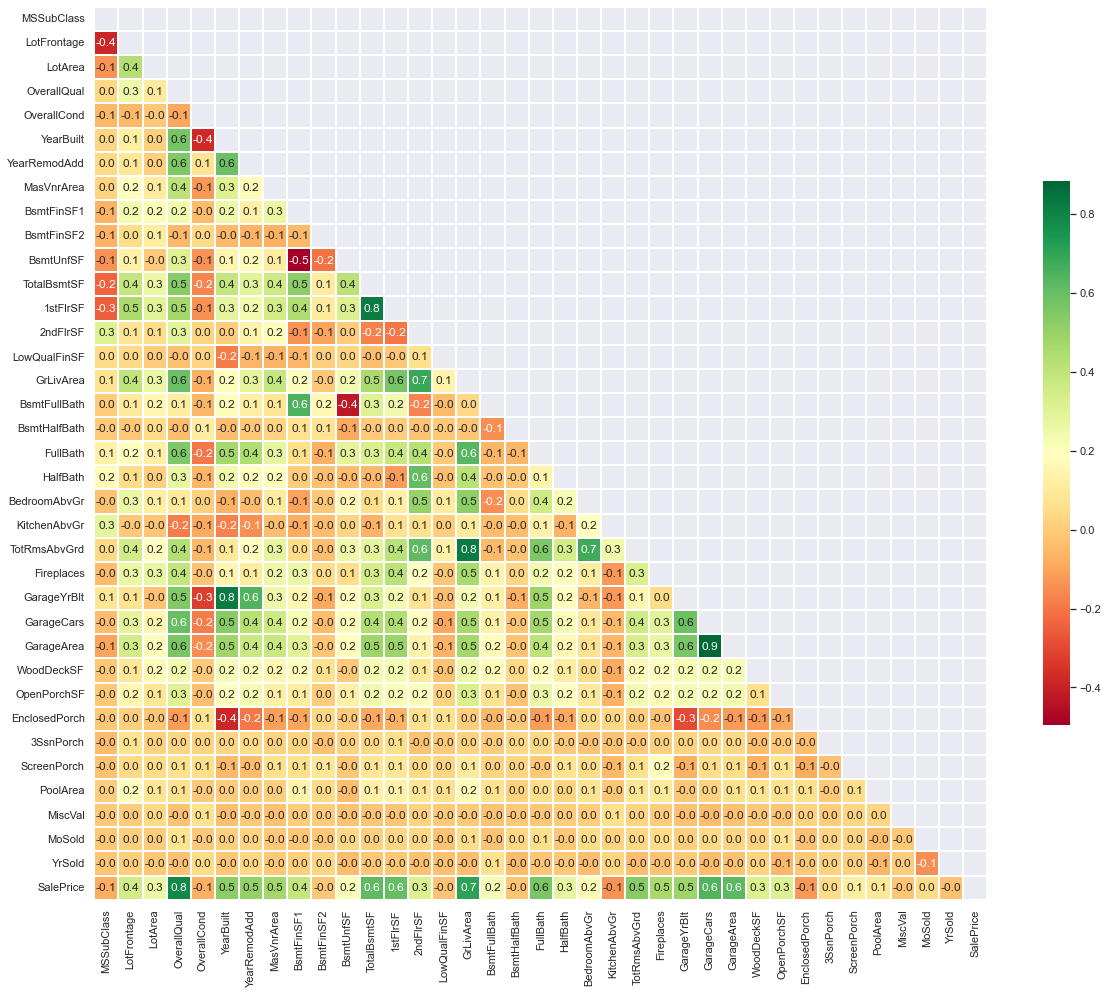

In [16]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, cmap='RdYlGn', square=True, cbar=True, cbar_kws={"shrink": .5}, linewidths=.1, mask=mask, annot=True, fmt=".1f")

Большая матрица 38x38 ячеек. И мы видим, там есть сильно коррелируемые объекты с нашей целевой переменной. 

- Нарисуйте крупно heatmap этих сильно коррелируемых объектов( больше 0.5 по абсолютному значению) и сделайте так, чтобы в каждой ячейке было значение корреляции. 
- Выведите список этих сильно коррелируемых признаков.

Запомним эти признаки!

<AxesSubplot:>

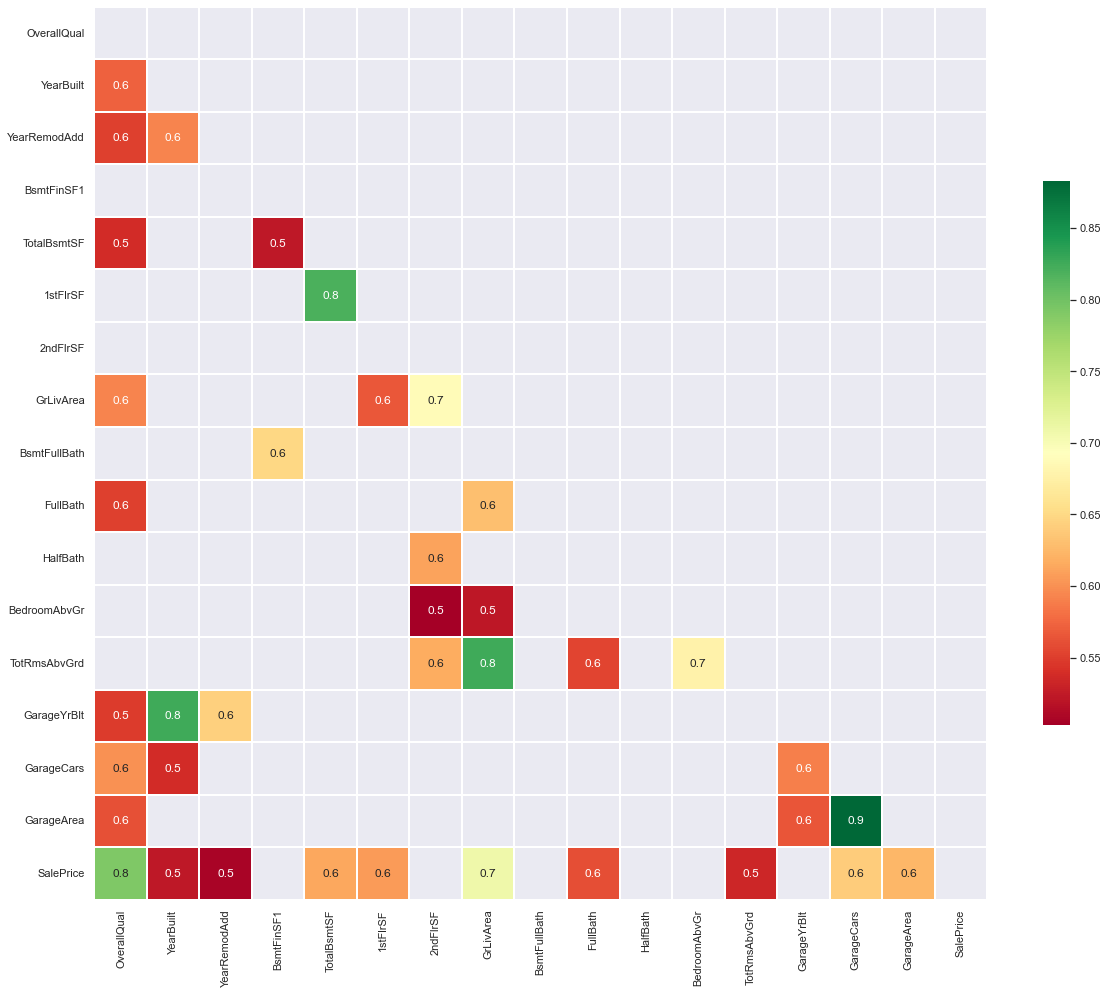

In [17]:
trunc_corr = corr[(np.abs(corr) > 0.5) & (np.abs(corr) != 1)].dropna(axis=0, how='all').dropna(axis=1, how='all')
mask = np.zeros_like(trunc_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(trunc_corr, cmap='RdYlGn', square=True, cbar=True, cbar_kws={"shrink": .5}, linewidths=.1, mask=mask, annot=True, fmt=".1f")

In [18]:
display(md(f"""**Коррелирующие признаки:**<br> {', <br>'.join(trunc_corr.columns.values)}"""))

**Коррелирующие признаки:**<br> OverallQual, <br>YearBuilt, <br>YearRemodAdd, <br>BsmtFinSF1, <br>TotalBsmtSF, <br>1stFlrSF, <br>2ndFlrSF, <br>GrLivArea, <br>BsmtFullBath, <br>FullBath, <br>HalfBath, <br>BedroomAbvGr, <br>TotRmsAbvGrd, <br>GarageYrBlt, <br>GarageCars, <br>GarageArea, <br>SalePrice

Я у нас умная, поэтому хочу посмотреть, какие признаки вносят наибольший вклад в стоимость дома, а так же посмотреть, нет ли ситуации, когда среди них оказываются сильно коррелирующие.

In [140]:
corr_with_target = set()
corr_with_each_other = set()
for row in corr.columns:
    for col in corr.columns:
        if row != col:
            if np.abs(corr.at[row, col]) > 0.5:
                if row == 'SalePrice' or col == 'SalePrice':
                    corr_with_target.add(row if row != 'SalePrice' else col)
                elif np.abs(corr.at[row, col]) > 0.8:
                    corr_with_each_other.add((row, col))

In [141]:
corr_with_target

{'1stFlrSF',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

In [142]:
corr_with_each_other

{('1stFlrSF', 'TotalBsmtSF'),
 ('GarageArea', 'GarageCars'),
 ('GarageCars', 'GarageArea'),
 ('GarageYrBlt', 'YearBuilt'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('TotRmsAbvGrd', 'GrLivArea'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('YearBuilt', 'GarageYrBlt')}

In [143]:
for feature1 in corr_with_target:  # это наиболее важные, но коррелирующие между собой признаки. нужно отобрать важные
    for feature2 in corr_with_target:
        if (feature1, feature2) in corr_with_each_other:
            print(feature1, feature2)

GarageArea GarageCars
TotRmsAbvGrd GrLivArea
1stFlrSF TotalBsmtSF
GarageCars GarageArea
TotalBsmtSF 1stFlrSF
GrLivArea TotRmsAbvGrd


In [144]:
final_list_of_features = ['1stFlrSF', 'FullBath', 'GarageArea', 'GrLivArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd']

## 1.3 Пропущеные данные (3 балла)

Задание:
 - Посчитайте общее количество пропущенных данных по каждому признаку
 - посчитайте долю пропущенных данных выборки
 - удалите из выборки признаки, доля пропущенных которых больще 10%
 - пропущенные категориальные заполните словом 'unknown' (у них dtype object)
 - пропущенные числовые заполните средним (у них dtype float)

Hinst: https://stackoverflow.com/a/38134049/3205200

In [19]:
overall = 0
for col in df.columns:
    overall += df[col].isna().sum()
    print(col, df[col].isna().sum(), end=', ')
print(f'Overall {overall}')

MSSubClass 0, MSZoning 0, LotFrontage 259, LotArea 0, Street 0, Alley 1369, LotShape 0, LandContour 0, Utilities 0, LotConfig 0, LandSlope 0, Neighborhood 0, Condition1 0, Condition2 0, BldgType 0, HouseStyle 0, OverallQual 0, OverallCond 0, YearBuilt 0, YearRemodAdd 0, RoofStyle 0, RoofMatl 0, Exterior1st 0, Exterior2nd 0, MasVnrType 8, MasVnrArea 8, ExterQual 0, ExterCond 0, Foundation 0, BsmtQual 37, BsmtCond 37, BsmtExposure 38, BsmtFinType1 37, BsmtFinSF1 0, BsmtFinType2 38, BsmtFinSF2 0, BsmtUnfSF 0, TotalBsmtSF 0, Heating 0, HeatingQC 0, CentralAir 0, Electrical 1, 1stFlrSF 0, 2ndFlrSF 0, LowQualFinSF 0, GrLivArea 0, BsmtFullBath 0, BsmtHalfBath 0, FullBath 0, HalfBath 0, BedroomAbvGr 0, KitchenAbvGr 0, KitchenQual 0, TotRmsAbvGrd 0, Functional 0, Fireplaces 0, FireplaceQu 690, GarageType 81, GarageYrBlt 81, GarageFinish 81, GarageCars 0, GarageArea 0, GarageQual 81, GarageCond 81, PavedDrive 0, WoodDeckSF 0, OpenPorchSF 0, EnclosedPorch 0, 3SsnPorch 0, ScreenPorch 0, PoolArea 0

In [20]:
leave_cols = []
for col in df.columns:
    if df[col].isna().sum() <= 0.1 * len(df[col]):
        leave_cols.append(col)
df_cleaned = df[leave_cols]

In [21]:
df_cleaned[df_cleaned.select_dtypes(include='object').columns] = df_cleaned[df_cleaned.select_dtypes(include='object').columns].fillna('unknown')
df_cleaned[df_cleaned.select_dtypes(include='float').columns] = df_cleaned[df_cleaned.select_dtypes(include='float').columns].fillna('unknown')

## 1.4 Категориальные переменные (1 балл)

На сколько вы помните, линейная регрессия не умеет обрабатывать категориальные признаки, так как ей нужны ЧИСЛА. Но не беда, в pandas есть встроенная функция [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html).

Задание:
- сконвертируйте все категориальные признаки(dtype=object) в вектора числовых с помощью get_dummies
- напечатайте сколько у вас теперь признаков
- Положите в переменную X все данные из датасета, кроме целевой переменной. Положите в переменную y только целевую переменную.

In [123]:
df_cleaned = pd.get_dummies(df_cleaned)
print('Теперь признаков', len(df_cleaned.columns))

Теперь признаков 705


In [153]:
y = df_cleaned['SalePrice']
X = df_cleaned.drop(columns='SalePrice')

## 1.5 Переобучение (3 балла)

Обучим обычную модель без регуляризации [sklearn.linear_model.LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

- Выведите все коэффициенты для каждого признака, отсортировав по возрастанию по модулю значения коэффициента. Используйте print и for, иначе jupyter схлопнет вывод numpy массива. Можете округлить коэффициенты до 2 знаков после запятой.
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)

In [148]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.preprocessing import StandardScaler

Без нормализации:

In [239]:
model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.9696299562008134

In [240]:
coefs = pd.DataFrame(model.coef_, index=X.columns, columns=['coef'])
coefs = coefs.sort_values('coef')
for i in range(len(coefs)):
    print(coefs.iloc[i].name, f"{coefs.iloc[i][0]:.2f}", end=', ')

MasVnrArea_796.0 -343118.15, RoofMatl_ClyTile -343118.15, MasVnrArea_762.0 -262802.38, GarageCond_Ex -128498.64, Condition2_PosN -122252.68, MasVnrArea_428.0 -115225.11, Condition2_RRAe -98924.39, MasVnrArea_209.0 -92570.73, MasVnrArea_432.0 -75474.21, MasVnrArea_287.0 -73164.29, GarageYrBlt_1918.0 -65097.14, MasVnrArea_184.0 -61800.12, MasVnrArea_435.0 -54885.93, MasVnrArea_230.0 -48379.01, Electrical_Mix -48259.12, MasVnrArea_286.0 -48202.98, GarageQual_Po -47476.41, MasVnrArea_1115.0 -46894.19, MasVnrArea_154.0 -46094.60, MasVnrArea_262.0 -46043.75, Exterior1st_ImStucc -42917.34, MasVnrArea_333.0 -41671.67, MasVnrArea_481.0 -40713.99, GarageYrBlt_1900.0 -40713.34, MasVnrArea_365.0 -38780.47, Functional_Sev -38341.89, MasVnrArea_472.0 -35982.41, MasVnrArea_289.0 -35782.16, MasVnrArea_584.0 -34704.89, GarageQual_Fa -34344.78, MasVnrArea_68.0 -33739.39, MasVnrType_None -33601.26, MasVnrArea_30.0 -32931.75, MasVnrArea_122.0 -30525.47, MasVnrArea_144.0 -29986.45, MasVnrArea_616.0 -29717.

GarageYrBlt_1940.0 7699.62, Neighborhood_NridgHt 7705.04, GarageYrBlt_1980.0 7776.15, MasVnrArea_368.0 7812.22, MasVnrArea_223.0 8038.01, GarageYrBlt_1939.0 8048.33, MasVnrArea_309.0 8233.78, Foundation_Stone 8296.80, MasVnrArea_158.0 8347.50, Street_Pave 8424.06, GarageYrBlt_1942.0 8444.56, MasVnrArea_244.0 8476.30, MasVnrArea_110.0 8502.99, MasVnrType_BrkCmn 8547.88, MasVnrArea_53.0 8571.34, MasVnrArea_772.0 8680.90, Exterior1st_MetalSd 8728.30, MasVnrArea_288.0 8896.95, MasVnrArea_660.0 8924.44, GarageYrBlt_1987.0 9124.11, MasVnrArea_168.0 9347.76, GarageYrBlt_1930.0 9349.60, MasVnrArea_80.0 9459.66, MasVnrArea_408.0 9478.88, Heating_Wall 9484.34, Heating_Grav 9569.55, MasVnrArea_28.0 9791.05, Exterior2nd_Other 9927.49, Condition1_Norm 10013.26, MasVnrArea_510.0 10109.60, MasVnrArea_40.0 10249.57, MasVnrArea_167.0 10455.78, Condition1_PosA 10569.03, MasVnrArea_147.0 10614.72, MasVnrArea_261.0 10619.46, MasVnrArea_102.0 10768.92, MasVnrArea_236.0 10873.71, MasVnrArea_140.0 10884.05, 

In [155]:
print("Среднее ошибки предсказания:", cv(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print("R^2:", r2_score(model.predict(X), y))

Среднее ошибки предсказания: -3.598445507958038e+20
R^2: 0.9686787277920114


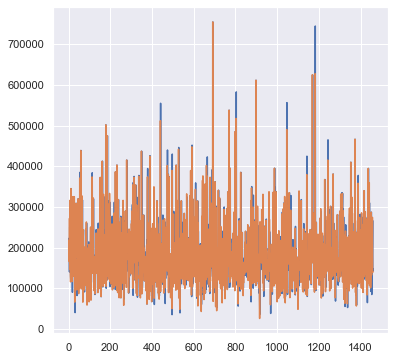

In [156]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y)
plt.plot(model.predict(X))

С нормализацией. Получается даже хуже:

In [157]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).reshape(1, -1)[0]

In [237]:
model = LinearRegression()
model.fit(X_scaled, y_scaled)
model.score(X_scaled, y_scaled)

0.9692917579063355

In [238]:
coefs = pd.DataFrame(model.coef_, index=X.columns, columns=['coef'])
coefs = coefs.sort_values('coef')
for i in range(len(coefs)):
    print(coefs.iloc[i].name, f"{coefs.iloc[i][0]:.2f}", end=', ')

LotConfig_Inside -2878459140685.68, LotConfig_Corner -2465171096411.94, MasVnrType_unknown -1674267427594.65, LotConfig_CulDSac -1574386634048.77, BsmtExposure_No -1526621827545.06, Utilities_NoSeWa -1505873411858.93, Condition2_PosN -1341793333743.66, BsmtExposure_Av -1149245541688.10, LotConfig_FR2 -1132249473809.84, Exterior2nd_CBlock -1034813339007.60, RoofMatl_Roll -997061178062.74, Exterior1st_VinylSd -992083304379.50, BsmtExposure_Gd -925774467282.06, MasVnrArea_796.0 -869490184382.63, BsmtExposure_Mn -860312024888.31, BsmtFinType1_unknown -846750164102.85, Foundation_PConc -791674139076.66, Foundation_CBlock -789921069579.21, Exterior1st_HdBoard -745530528270.77, Exterior1st_MetalSd -742763929665.85, Exterior1st_Wd Sdng -722788111586.37, LandContour_Lvl -697136139261.04, Condition2_Norm -696018771127.41, GrLivArea -690730426784.03, GarageType_Attchd -621046267525.04, GarageType_Detchd -558590656976.04, Exterior1st_Plywood -543411526038.72, BsmtExposure_unknown -510531606657.44,

MasVnrArea_573.0 -25966882080.75, MasVnrArea_415.0 -25966882080.75, MasVnrArea_426.0 -25966882080.75, MasVnrArea_138.0 -25966882080.75, MasVnrArea_310.0 -25966882080.75, MasVnrArea_530.0 -25966882080.75, MasVnrArea_554.0 -25966882080.75, MasVnrArea_219.0 -25966882080.75, MasVnrArea_366.0 -25966882080.75, MasVnrArea_451.0 -25966882080.75, MasVnrArea_237.0 -25966882080.75, MasVnrArea_452.0 -25966882080.75, MasVnrArea_921.0 -25966882080.75, MasVnrArea_450.0 -25966882080.75, MasVnrArea_438.0 -25966882080.75, MasVnrArea_57.0 -25966882080.75, MasVnrArea_1600.0 -25966882080.75, MasVnrArea_342.0 -25966882080.75, MasVnrArea_156.0 -25966882080.75, MasVnrArea_290.0 -25966882080.75, MasVnrArea_27.0 -25966882080.75, MasVnrArea_280.0 -25966882080.75, MasVnrArea_768.0 -25966882080.75, MasVnrArea_459.0 -25966882080.75, MasVnrArea_46.0 -25966882080.75, MasVnrArea_88.0 -25966882080.75, MasVnrArea_500.0 -25966882080.75, MasVnrArea_299.0 -25966882080.75, MasVnrArea_473.0 -25966882080.75, MasVnrArea_766.0 

48268158917.31, GarageYrBlt_1974.0 48268158917.32, GarageYrBlt_1995.0 48268158917.32, GarageYrBlt_1960.0 49573620986.81, GarageYrBlt_1954.0 49573620986.81, GarageYrBlt_1978.0 49573620986.81, GarageYrBlt_1997.0 49573620986.82, Neighborhood_CollgCr 50535432559.19, GarageYrBlt_1957.0 50843810929.80, GarageYrBlt_1970.0 50843810929.80, GarageYrBlt_2001.0 50843810929.81, GarageYrBlt_1996.0 50843810929.81, HeatingQC_Gd 51812748223.22, GarageYrBlt_1965.0 52081309523.01, GarageYrBlt_1958.0 52081309523.03, GarageYrBlt_1966.0 52081309523.03, GarageYrBlt_2009.0 52081309523.03, GarageYrBlt_1962.0 52081309523.04, GarageYrBlt_1993.0 53288394356.04, Electrical_FuseF 54526532196.07, LotShape_IR2 54879353708.52, GarageYrBlt_1950.0 55619194122.23, GarageYrBlt_1968.0 57849965040.16, GarageYrBlt_2002.0 57849965040.17, GarageYrBlt_2000.0 58931409492.62, Neighborhood_NAmes 60095153372.78, GarageYrBlt_1976.0 61032430747.91, GarageYrBlt_2008.0 61032430747.94, GarageCond_Ex 61855922583.81, GarageYrBlt_1999.0 62

In [159]:
print("Среднее ошибки предсказания:", cv(model, X_scaled, y_scaled, cv=5, scoring='neg_mean_squared_error').mean())
print("R^2:", r2_score(model.predict(X_scaled), y_scaled))

Среднее ошибки предсказания: -7.700783768774665e+26
R^2: 0.9682538697962734


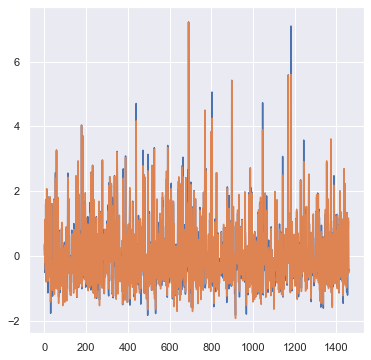

In [160]:
fig = plt.figure(figsize=(6, 6))
plt.plot(y_scaled)
plt.plot(model.predict(X_scaled))

К счастью в этот раз коэффициенты при признаках не улетели в космос, но всё равно достигли очень больших значений. Например `RoofStyle_Shed` получился в моем случае около `-514961`. А у некоторых признаков коэффициент уже равен 0, хотя не была применена регуляризация.

## 1.6 Ridge и Lasso (4 балла)

- Обучите Lasso и Ridge для разных значений регуляризации alpha
- нарисуйте график значений коэффициентов модели для каждого признака, как мы делали на практике. По оси X будет значение alpha, по Y - значение коэффициента. на графике будет "радуга" из линий разных цветов(линий столько, сколько признаков).
- Нарисуйте гистограмму, в которой по оси Y будет количество коэффициентов, равных 0 (<0.0001) для Loss регресиии, а по оси X - значение коэффициента альфа.

alpha взять от 1 до 500 с каким-нибудь шагом. Но не переборщите, а то долго будете ждать.

In [234]:
from sklearn.linear_model import Lasso, Ridge, LassoCV

In [203]:
history_l = []
history_r = []
for alpha in range(1, 500, 10):
    model_l = Lasso(alpha=alpha)
    model_l.fit(X, y)
    history_l.append(model_l.coef_)
    model_r = Ridge(alpha=alpha)
    model_r.fit(X, y)
    history_r.append(model_l.coef_)
history_l = np.array(history_l)
history_r = np.array(history_r)

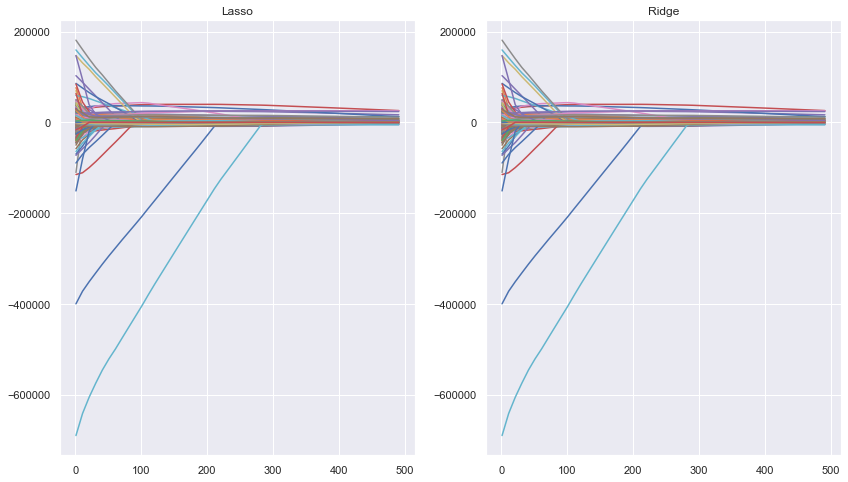

In [204]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))
axes[0].plot(range(1, 500, 10), history_l)
axes[0].set_title('Lasso')
axes[1].plot(range(1, 500, 10), history_r)
axes[1].set_title('Ridge')
plt.show()

<BarContainer object of 50 artists>

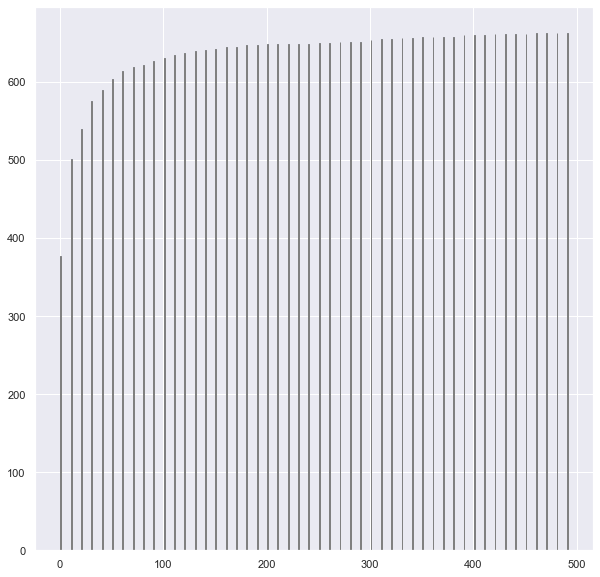

In [232]:
fig = plt.figure(figsize=(10, 10))
amount = []
for row in history_l:
    amount.append(len(row[row < 0.0001]))
plt.bar(range(1, 500, 10), amount, edgecolor='gray')

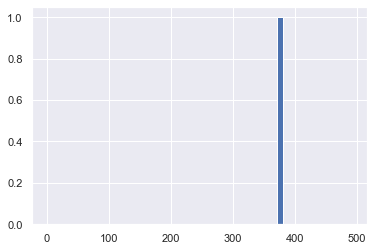

In [226]:
plt.hist(amount, range(1, 500, 10))
plt.show()

## 1.7 Поиск оптимального alpha (6 баллов)

- С помощью метода LassoCV найдите оптимальное значение alpha и напечатайте его, используя разбиение на 5 фолда в кроссвалидации (`cv=5`).
- Нарисуйте график зависимости MSE от alpha (`mse_path_`).
- Нарисуйте длинную гистограмму магнитуда признаков, как в классе, на которой будет показано значение коэффициента для каждого признака. Графк должен быть остортирован по величине коэффициентов. Признаки с нулевыми коэффициентами должны быть удалены.
- Сколько в итоге ненулевых признаков осталось?
- Выведите **среднее** ошибки предсказания на 5 фолдах (cv=5) для этой линейной регрессии с помощью функции [sklearn.model_selection.cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). Укажите `scoring='neg_mean_squared_error'`, чтобы считалась [MSE](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error). Качество должно быть лучше, чем у простой линейной регрессии.

In [279]:
model = LassoCV(alphas=range(1, 500, 5), cv=5).fit(X, y)
model.score(X, y)

0.9039126149614471

In [280]:
model.alpha_

176

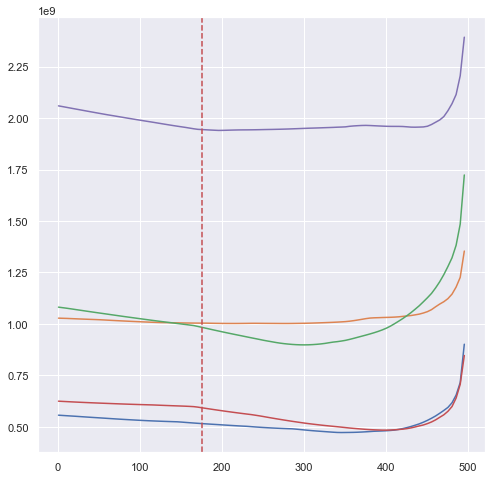

In [281]:
fig = plt.figure(figsize=(8, 8))
plt.plot(range(1, 500, 5), model.mse_path_)
plt.axvline(x=model.alpha_, linestyle='--', c='r')
plt.show()

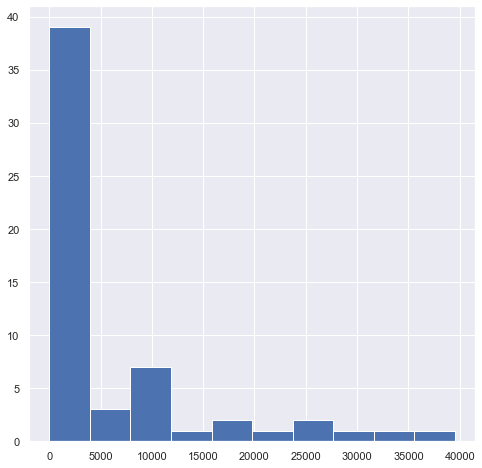

In [282]:
fig = plt.figure(figsize=(8, 8))
plt.hist(model.coef_[model.coef_ >= 0.0001])
plt.show()

In [283]:
len(model.coef_[model.coef_ >= 0.0001])

58

In [284]:
print("Среднее ошибки предсказания:", cv(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
print("R^2:", r2_score(model.predict(X), y))

Среднее ошибки предсказания: -987447506.752359
R^2: 0.8886759114061558


## 1.8 Предсказание на отложенной выборке (3 балла)

- Используя [sklearn.model_selection.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбейте датасет на 2 части - тренировочную и тестовую в соотношении 0.33. Не забудьте перемешать!
- Напечатайте размерность X_train и X_test

In [292]:
from sklearn.model_selection import train_test_split

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

In [296]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((978, 704), (482, 704), (978,), (482,))

Теперь, возьмите вашу самую мощную модель(не тренированную!). Запустите её тренировку по тренировочной выборке X_train, y_train с помощью функции `fit`. Постройте предсказания с помощью функции `predict`.

In [297]:
model = LassoCV(alphas=range(1, 500, 5), cv=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Визуализируйте scatter plot предсказанных значений и настоящих (`y_test`). У вас должен получиться график, точки которого расположены приблизительно вдоль некоторой прямой с разбросом. Идеальный предсказатель будет выглядить как набор точек вдоль прямой без разброса.

<AxesSubplot:ylabel='SalePrice'>

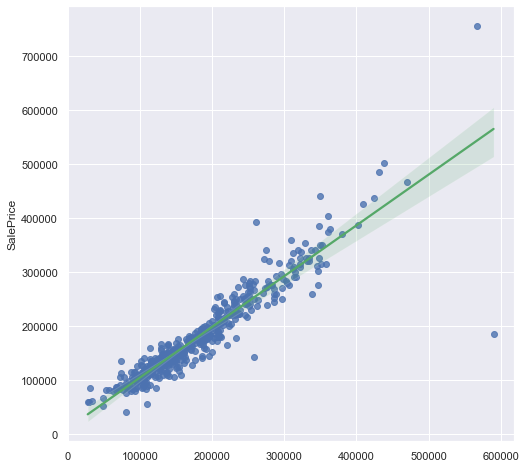

In [310]:
fig = plt.figure(figsize=(8, 8))
sns.regplot(y_pred, y_test, line_kws={'color': 'g'})

## 1.9 Ограниченная версия ( 4 балла)

Помните в самом начале мы оставили очень мало признаков по данным из heatmap. Настало время проверить как он себя покажет! К счастью они все сразу числовые, а не категориальные. Переиспользуйте тот дадасет, где вы уже поборолись с пропусками.
Снова выделите отдельно X и y и запустите кроссвалидацию c 5 фолдами по Lasso с `alpha=1`.

In [314]:
X, y = df_cleaned[corr_with_target], df_cleaned['SalePrice']

In [322]:
model = Lasso(alpha=1)
print("Среднее ошибки предсказания:", cv(model, X, y, cv=5, scoring='neg_mean_squared_error').mean())
model.fit(X, y)
print("R^2:", r2_score(model.predict(X), y))

Среднее ошибки предсказания: -1529885450.9328089
R^2: 0.707492929125265


Можете посмотреть еще много разных примеров обработки этого датасета тут: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels

А суть всего этого такова, что в итоге надо кучу времени потратить на подготовку признаков. Смотреть на кучу графиков а потом стакать модели.